In [17]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [18]:
dir = Path("../data/source/images")
imgs_filenames = ["40654268451-px_500.jpg", "14688551481-large.jpg", "9845751214-large.jpg", "22280981189-px_500.jpg", "11446625684-large.jpg", "24818281700-px_500.jpg", "temp.jpg", "Untitled.png"]

# Edge density & Orientation entropy

Understanding the process of canny edge detection

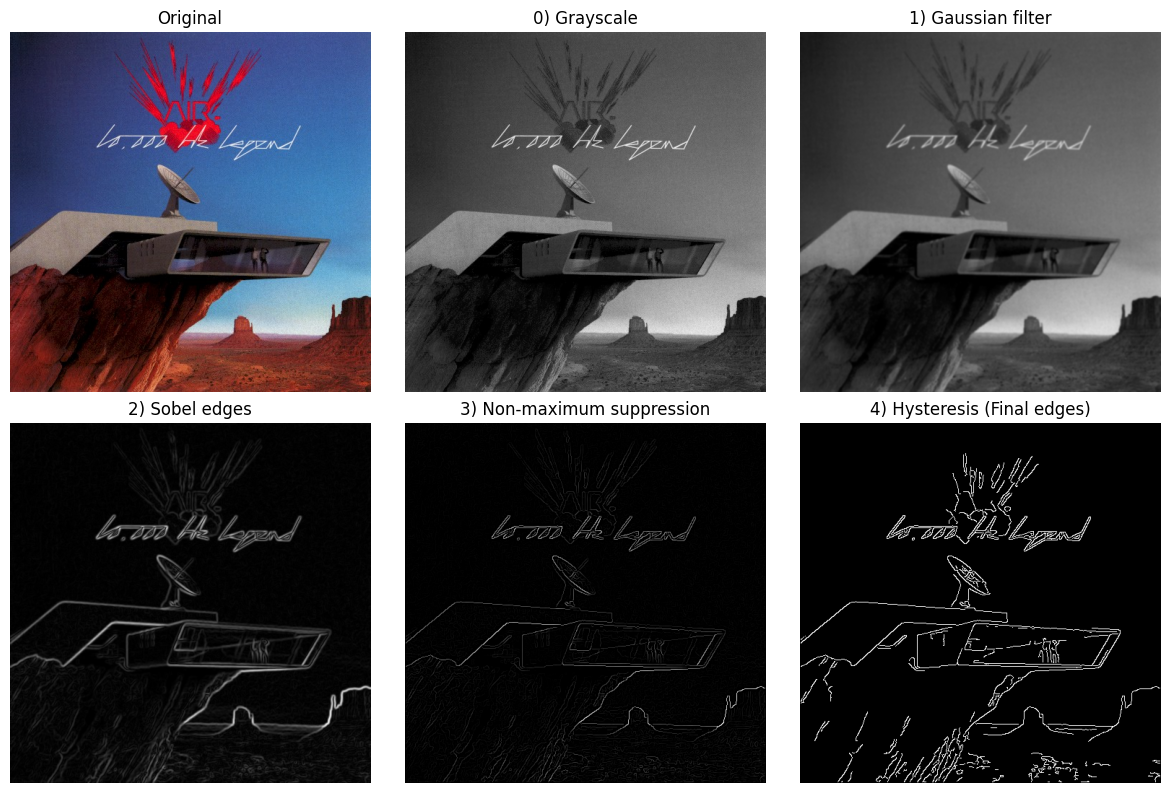

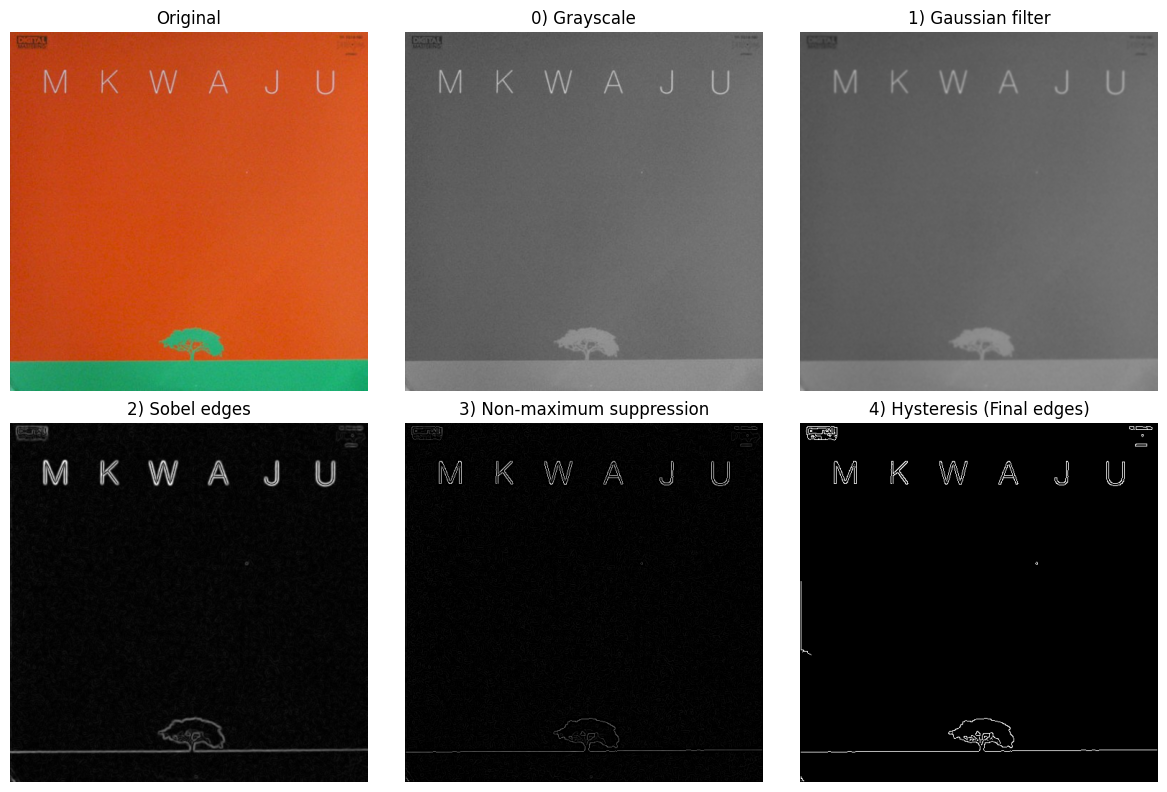

In [19]:
import numpy as np
from scipy.ndimage import convolve
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray

# Import slightly adapted functions from reference article to understand steps

def gaussian_kernel(size: int, sigma: float = 1.4) -> np.ndarray:
    half = int(size) // 2
    y, x = np.mgrid[-half:half+1, -half:half+1]
    normal = 1.0 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
    return g.astype(np.float32)

def sobel_filters(img: np.ndarray):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]], dtype=np.float32)

    Ix = convolve(img, Kx, mode="reflect")
    Iy = convolve(img, Ky, mode="reflect")

    G = np.hypot(Ix, Iy).astype(np.float32)
    G = (G / (G.max() + 1e-8) * 255.0).astype(np.float32)  # match repo scaling
    theta = np.arctan2(Iy, Ix).astype(np.float32)
    return G, theta

def non_max_suppression(mag: np.ndarray, angles: np.ndarray) -> np.ndarray:
    """
    Thin edges by suppressing non-maxima along the local gradient direction.
    Expects:
      - mag: gradient magnitude (float array)
      - angles: gradient orientation in radians, same shape as mag
    Returns:
      - nms: thinned magnitude map (float32), zeros where suppressed
    """

    nms = np.zeros_like(mag, dtype=np.float32)  # output initialized to zero (suppressed everywhere)
    angle = (np.degrees(angles) % 180.0).astype(np.float32)  # convert radians -> degrees and wrap to [0,180)

    H, W = mag.shape  # image size (rows, cols)

    # loop over interior pixels (borders are skipped because they lack two neighbors)
    for i in range(1, H - 1):  # rows 1..H-2
        for j in range(1, W - 1):  # cols 1..W-2
            a = angle[i, j]  # local orientation in degrees
            m = mag[i, j]    # local magnitude

            # pick the two neighbors to compare with, aligned with the quantized direction
            # four bins: 0°, 45°, 90°, 135°
            if (0.0 <= a < 22.5) or (157.5 <= a <= 180.0):
                q = mag[i, j + 1]   # neighbor in +x
                r = mag[i, j - 1]   # neighbor in -x
            elif (22.5 <= a < 67.5):
                q = mag[i + 1, j - 1]  # neighbor at +45° (down-left)
                r = mag[i - 1, j + 1]  # neighbor at -135° (up-right)
            elif (67.5 <= a < 112.5):
                q = mag[i + 1, j]   # neighbor in +y
                r = mag[i - 1, j]   # neighbor in -y
            else:  # (112.5 <= a < 157.5)
                q = mag[i - 1, j - 1]  # neighbor at -45° (up-left)
                r = mag[i + 1, j + 1]  # neighbor at +135° (down-right)

            # keep a pixel only if it is a local maximum along the gradient direction
            if (m >= q) and (m >= r):
                nms[i, j] = m       # keep the magnitude (unsuppressed)
            # else: leave as 0 (suppressed)

    return nms
    
def threshold(img: np.ndarray, lowThresholdRatio: float = 0.05, highThresholdRatio: float = 0.15):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold  = highThreshold * lowThresholdRatio

    res = np.zeros(img.shape, dtype=np.int32)
    weak, strong = np.int32(75), np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i,   weak_j   = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i,   weak_j]   = weak
    return res, weak, strong

def hysteresis(img: np.ndarray, weak: int, strong: int = 255) -> np.ndarray:
    M, N = img.shape
    out = img.copy()
    for i in range(1, M-1):
        for j in range(1, N-1):
            if out[i, j] == weak:
                if ((out[i+1, j-1] == strong) or (out[i+1, j] == strong) or (out[i+1, j+1] == strong) or
                    (out[i,   j-1] == strong) or                             (out[i,   j+1] == strong) or
                    (out[i-1, j-1] == strong) or (out[i-1, j] == strong) or (out[i-1, j+1] == strong)):
                    out[i, j] = strong
                else:
                    out[i, j] = 0
    return out

# Loop over somedev_set images to show steps of canny edge detector (raw implementation)
for filename in imgs_filenames[:2]:
    path = dir / filename
    img = Image.open(path)

    # 0) Grayscale
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    # 1) Gaussian filter (repo-style)
    kernel = gaussian_kernel(size=5, sigma=1.0)         # same defaults as the article
    smoothed = convolve(gray01.astype(np.float32), kernel, mode="reflect")

    # 2) Sobel gradients (repo-style normalization to 0..255)
    mag_255, angles = sobel_filters(smoothed)
    thr = np.percentile(mag_255, 90)
    sobel_edges = mag_255 > thr

    # 3) Non-maximum suppression
    nms = non_max_suppression(mag_255, angles)

    # 4) Double threshold + hysteresis (repo-style, integer labels)
    labels, WEAK, STRONG = threshold(nms, lowThresholdRatio=0.05, highThresholdRatio=0.15)
    final_edges_u8 = hysteresis(labels, WEAK, STRONG)   # values in {0, 75, 255}
    final_edges_bool = (final_edges_u8 == STRONG)       # convenient for overlay/plotting


    # Show
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("0) Grayscale")
    ax2.axis("off")

    ax3.imshow(smoothed, cmap="gray", vmin=0, vmax=1)
    ax3.set_title("1) Gaussian filter")
    ax3.axis("off")

    ax4.imshow(mag_255, cmap="gray", vmin=0, vmax=255)
    ax4.set_title(f"2) Sobel edges")
    ax4.axis("off")

    ax5.imshow(nms, cmap="gray", vmin=0, vmax=255)
    ax5.set_title("3) Non-maximum suppression")
    ax5.axis("off")

    ax6.imshow(final_edges_bool, cmap="gray")
    ax6.set_title("4) Hysteresis (Final edges)")
    ax6.axis("off")

    plt.tight_layout()
    plt.show()


Testing our implementation

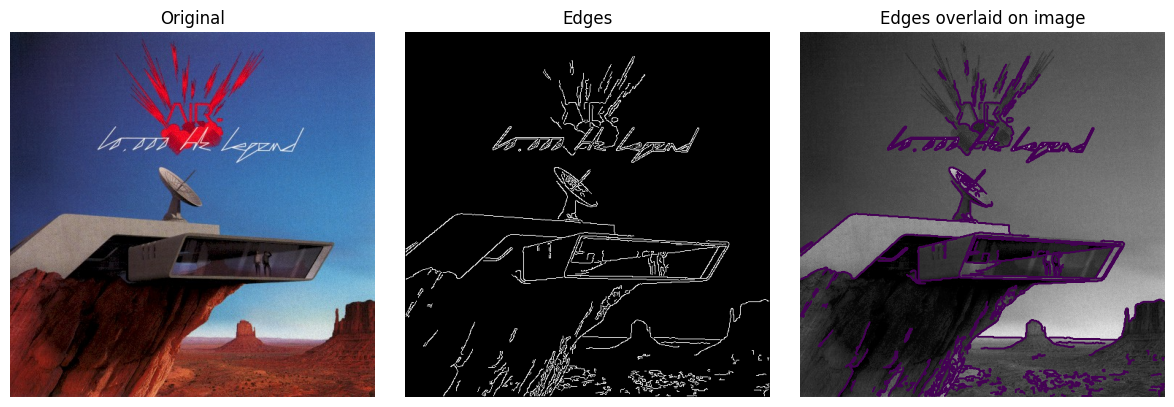

40654268451-px_500.jpg
edge_density: 0.04042
edge_orientation_entropy: 0.95025173360843


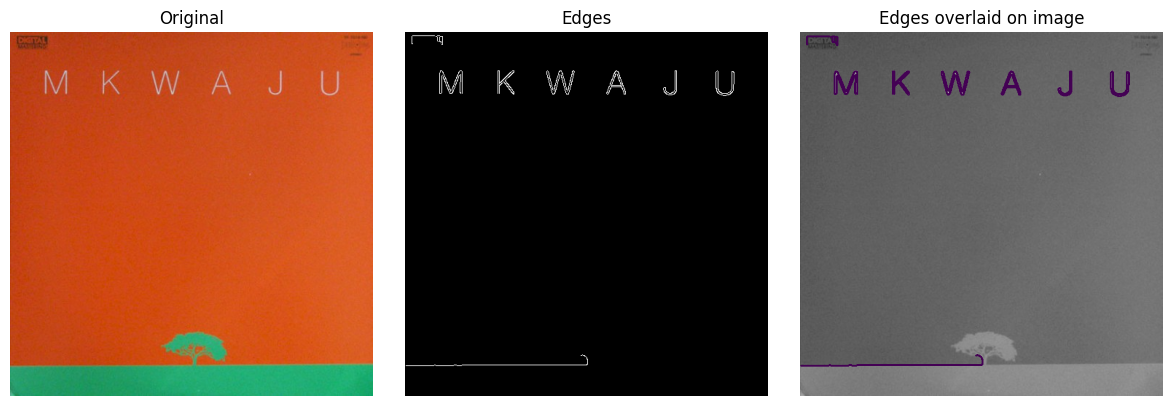

14688551481-large.jpg
edge_density: 0.005967871485943775
edge_orientation_entropy: 0.9572300267973277


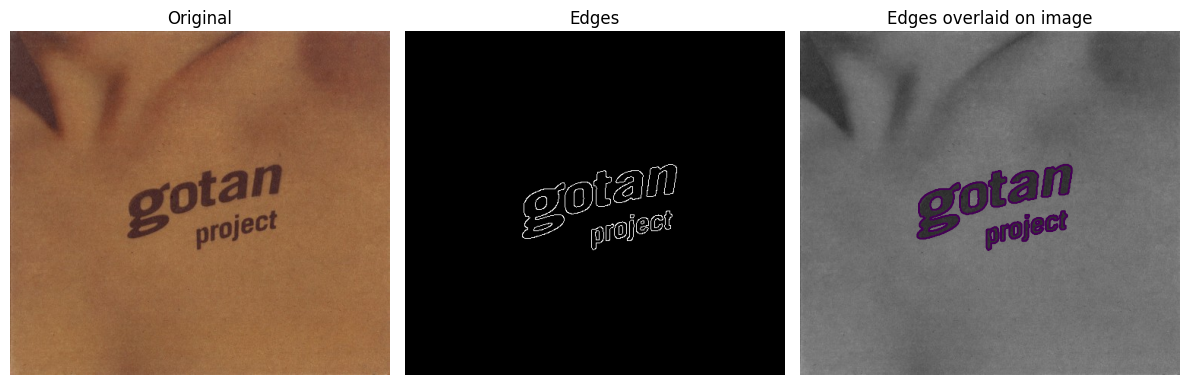

9845751214-large.jpg
edge_density: 0.008376106194690265
edge_orientation_entropy: 0.9830463823299476


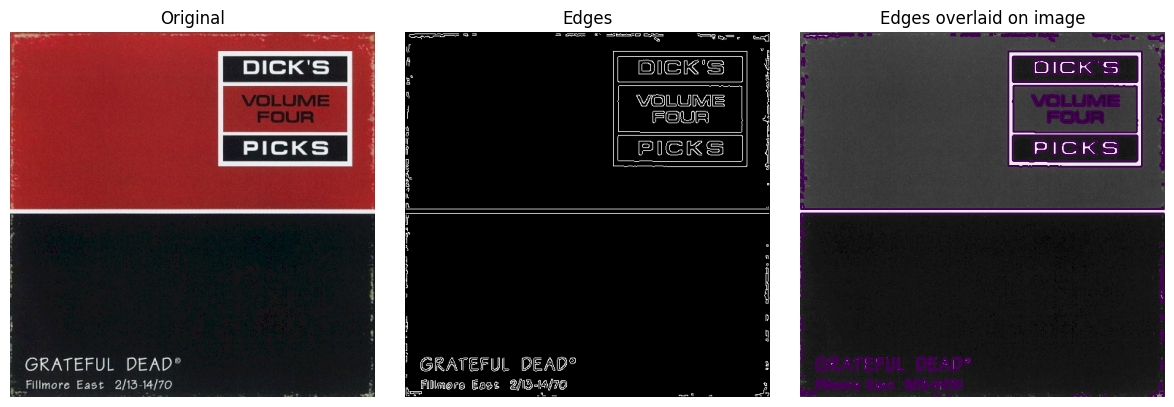

22280981189-px_500.jpg
edge_density: 0.034844
edge_orientation_entropy: 0.787579587421295


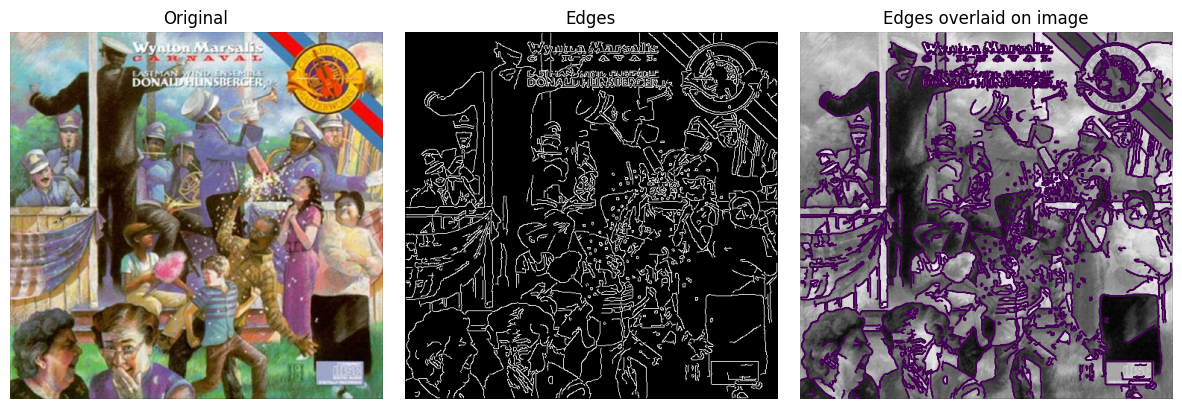

11446625684-large.jpg
edge_density: 0.11604868154158215
edge_orientation_entropy: 0.9865488602225435


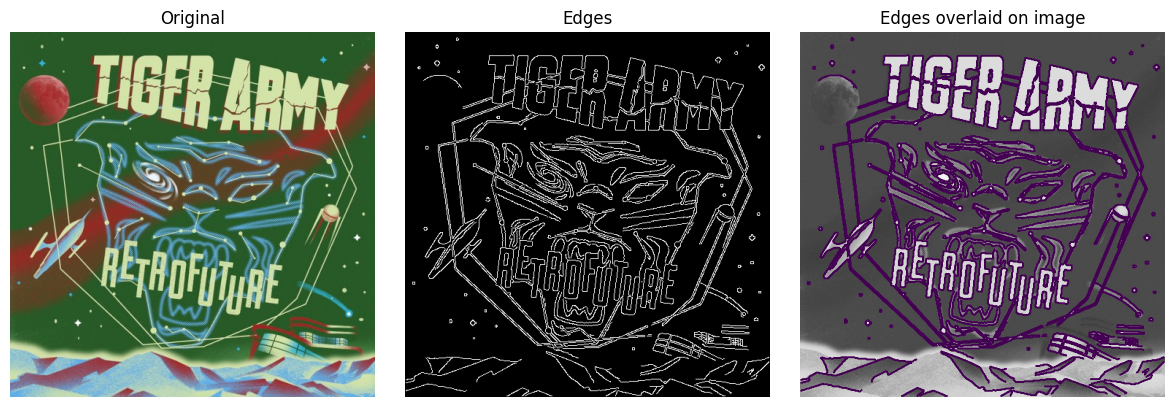

24818281700-px_500.jpg
edge_density: 0.089616
edge_orientation_entropy: 0.952259328519514


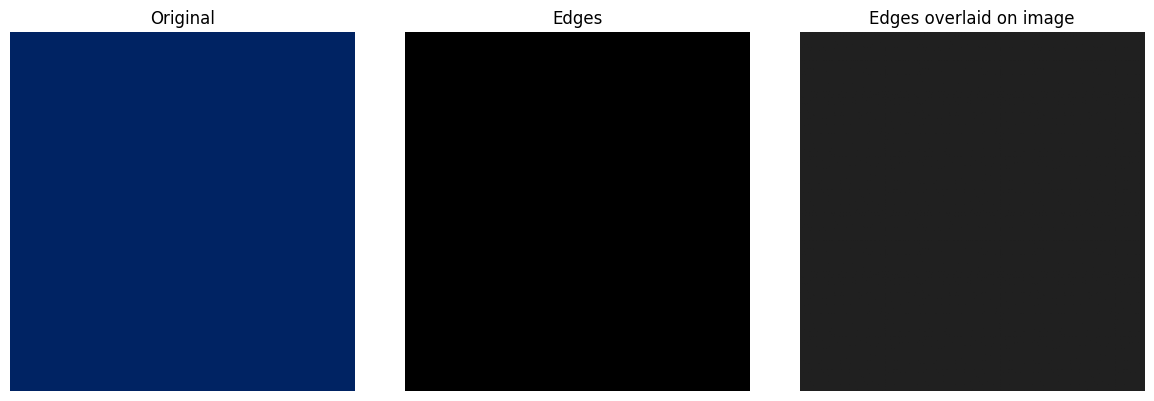

temp.jpg
edge_density: 0.0
edge_orientation_entropy: 0.0


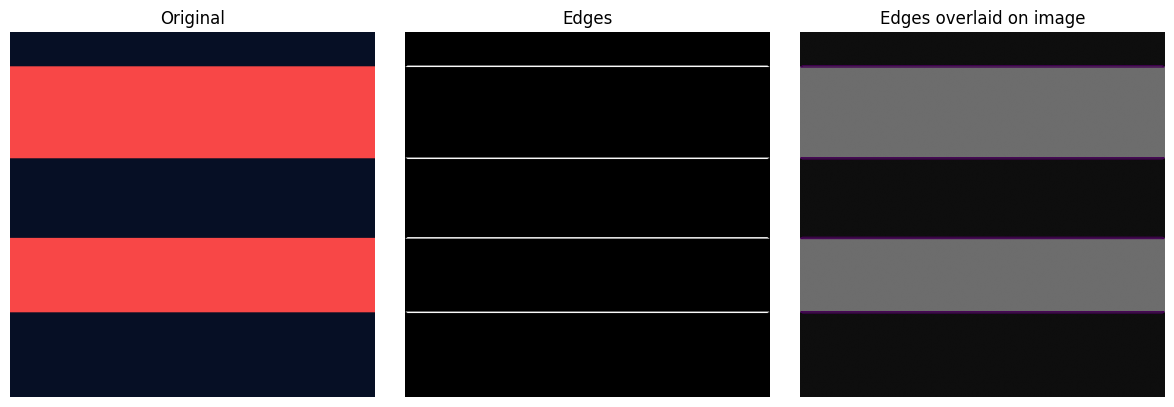

Untitled.png
edge_density: 0.015872
edge_orientation_entropy: 0.004991473788605559


In [21]:
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray
from albcovis.services.texture_descriptors import compute_canny_edges, compute_sobel_gradients, edge_density, orientation_entropy_from_sobel

# Loop over some dev_set images to show our implementation of canny edge detector for this project

for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)

    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    # 2) Canny edges
    edges = compute_canny_edges(gray01, sigma=0.75)
    ed = edge_density(edges)

    # 3) Sobel orientation entropy
    gx, gy, mag = compute_sobel_gradients(gray01)
    oe = orientation_entropy_from_sobel(gx, gy, mag, nbins=18)

    # Show
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(edges, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("Edges")
    ax2.axis("off")

    ax3.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax3.contour(edges, levels=[0.5], linewidths=0.8)
    ax3.set_title("Edges overlaid on image")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    print(filename)
    print(f"edge_density: {ed}")
    print(f"edge_orientation_entropy: {oe}")


# Pixel intensity entropy

> ¿Porqué usar shannon entropy y no usar varianza o dev. estándar?

In [22]:
from albcovis.services.texture_descriptors import compute_entropy_gray

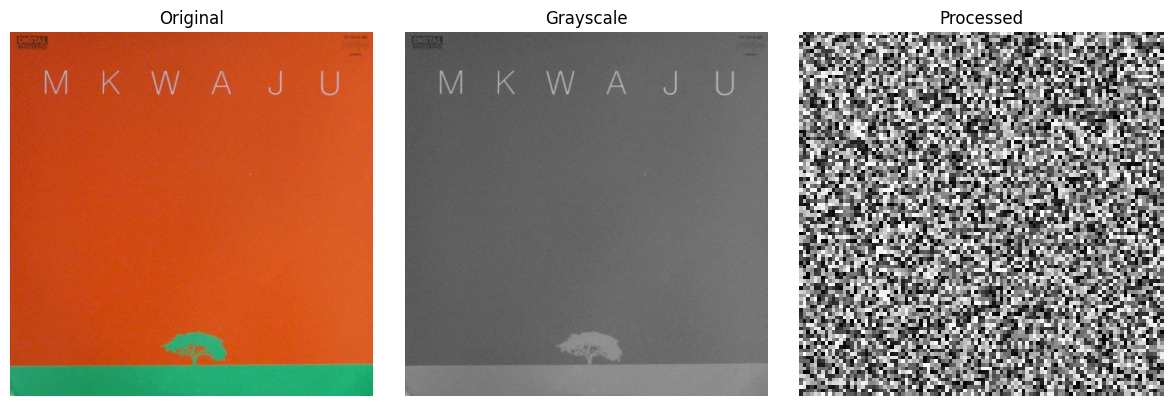

In [23]:
import matplotlib.pyplot as plt
import numpy as np
img = Image.open(dir / imgs_filenames[1])
rgb01 = pil_to_numpy01(img)
gray01 = rgb_to_gray(rgb01)

# Example: create a random grayscale image
# image = np.random.rand(100, 100)  # values in [0,1]

import matplotlib.pyplot as plt
import numpy as np

# Example images
original = img # RGB image
grayscale = gray01     # grayscale image
processed = np.random.rand(100, 100)     # processed grayscale

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax1.imshow(original)
ax1.set_title("Original")
ax1.axis("off")

# Grayscale
ax2.imshow(grayscale, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Grayscale")
ax2.axis("off")

# Processed
ax3.imshow(processed, cmap="gray", vmin=0, vmax=1)
ax3.set_title("Processed")
ax3.axis("off")

plt.tight_layout()
plt.show()




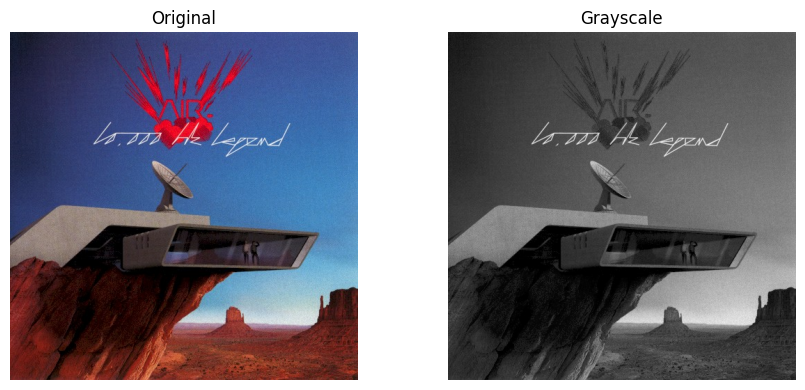

40654268451-px_500.jpg
entropy_val: 0.9225757963753831


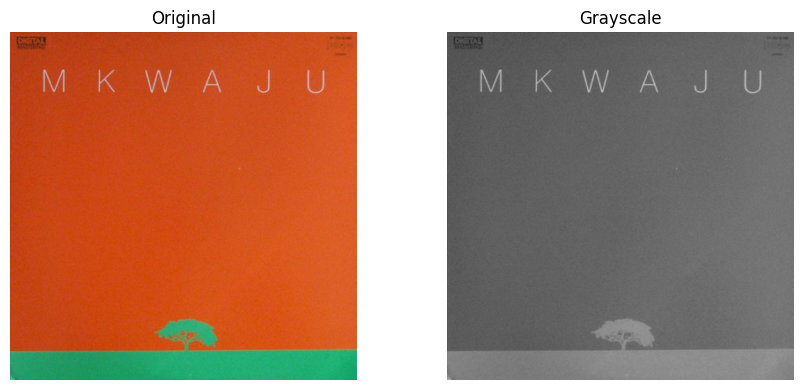

14688551481-large.jpg
entropy_val: 0.6941733702780352


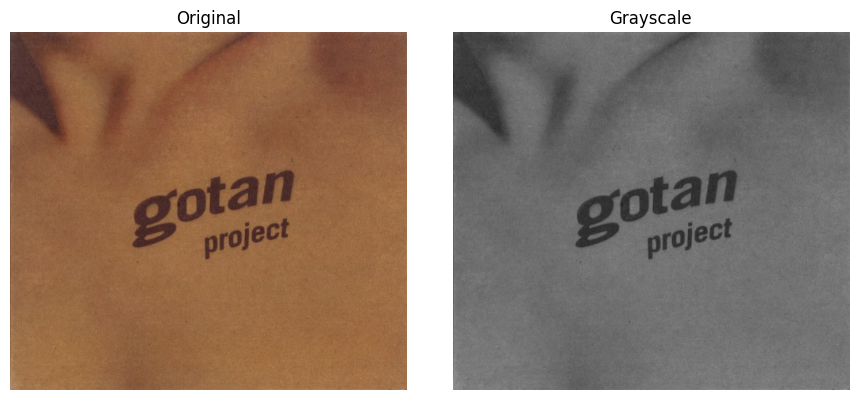

9845751214-large.jpg
entropy_val: 0.6881241928750881


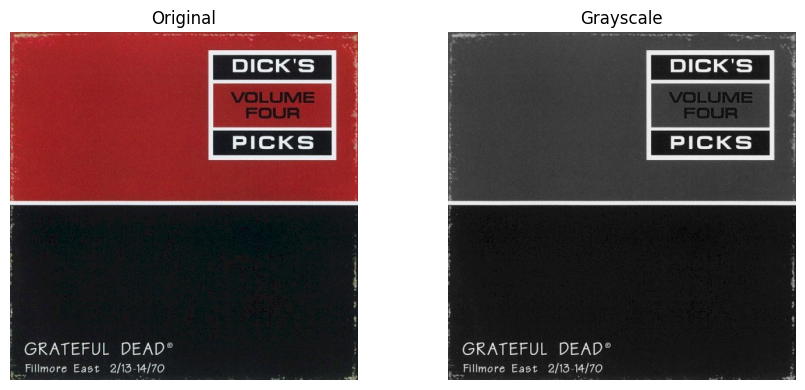

22280981189-px_500.jpg
entropy_val: 0.7275755849607602


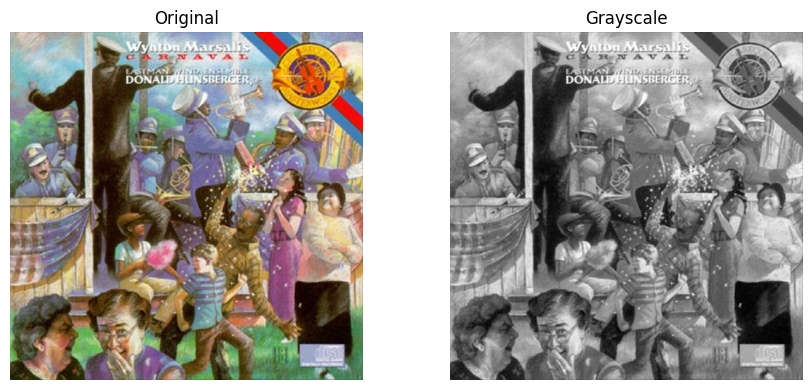

11446625684-large.jpg
entropy_val: 0.9718208705719185


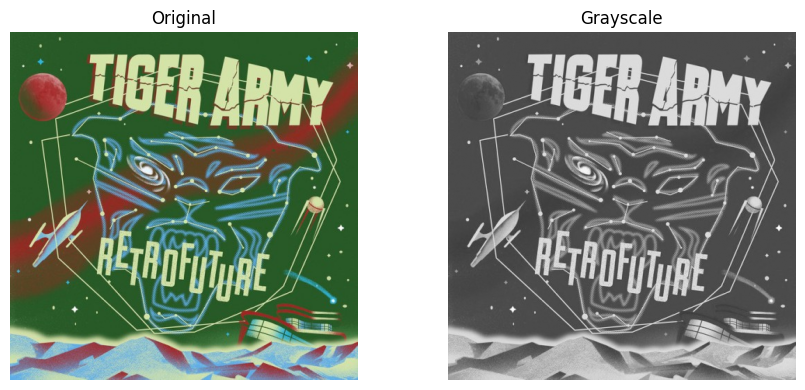

24818281700-px_500.jpg
entropy_val: 0.7502712481609275


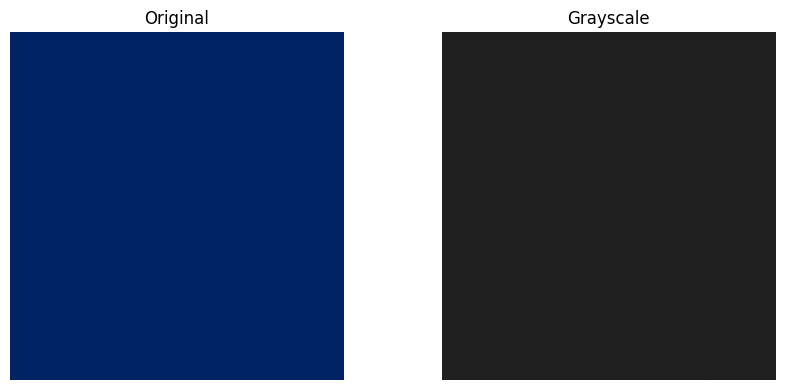

temp.jpg
entropy_val: -0.0


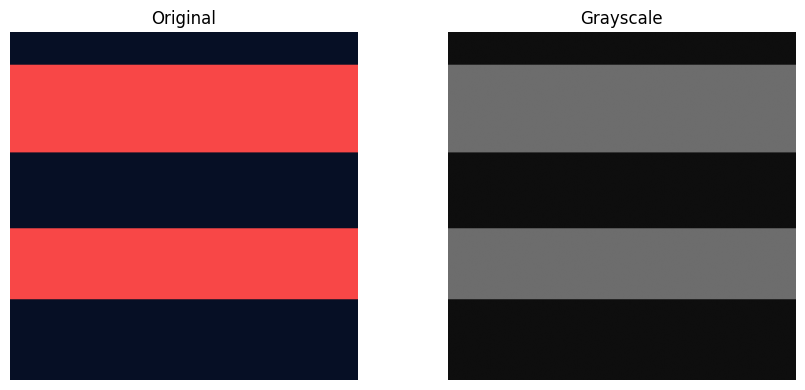

Untitled.png
entropy_val: 0.12430083157034752


In [24]:
for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("Grayscale")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    print(filename)

    entropy_val = compute_entropy_gray(gray01)

    print(f"entropy_val: {entropy_val}")
